In [65]:
from sklearn.linear_model import LogisticRegression
import pandas as pd 
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

X = pd.read_pickle("X.pkl")
features = X.columns
y = pd.read_pickle("y.pkl")
y = np.ravel(y)

print(features)

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking'],
      dtype='object')


C:\Users\User\AppData\Local\Temp\ipykernel_21380\3823345811.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=top_features, patch_artist=True)


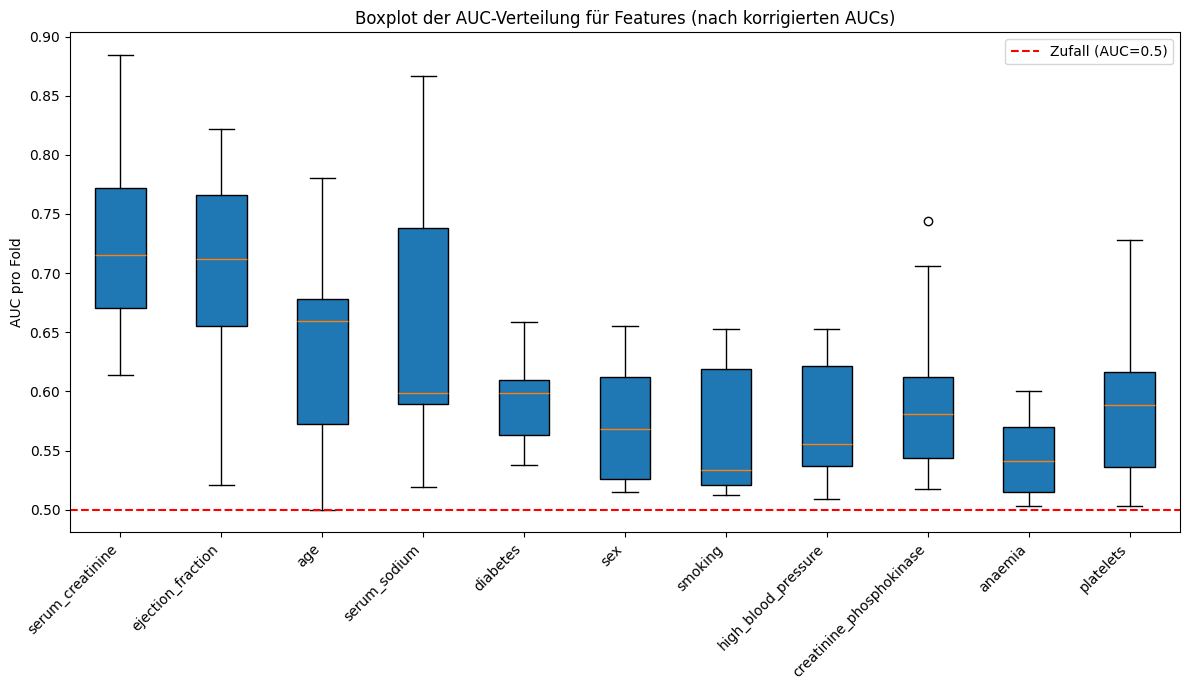

In [66]:
feature_auc_scores = {}
feature_all_auc_scores = {}
cv = StratifiedKFold(n_splits=10, shuffle = True,random_state=1)

for feature in features:
    model = LogisticRegression()
    auc_scores = cross_val_score(
        model, X[[feature]], y,
        cv=cv,  # 5-fold cross-validation
        scoring='roc_auc'
    )

    # Mittelwert speichern
    auc_score = np.mean(auc_scores)
    if auc_score < 0.5:
        auc_score = 1 - auc_score
    feature_auc_scores[feature] = auc_score
    feature_all_auc_scores[feature] = np.where(auc_scores < 0.5, 1 - auc_scores, auc_scores)
    
sorted_features = sorted(feature_auc_scores.items(), key=lambda x: x[1], reverse=True)
top_features = [f for f, _ in sorted_features]  # alle Features sortiert

# Boxplot-Daten vorbereiten (alle Features)
boxplot_data = [feature_all_auc_scores[f] for f in top_features]

# Plot
plt.figure(figsize=(12, 7))
plt.boxplot(boxplot_data, labels=top_features, patch_artist=True)
plt.xticks(rotation=45, ha='right')
plt.axhline(0.5, color='red', linestyle='--', label='Zufall (AUC=0.5)')
plt.ylabel("AUC pro Fold")
plt.title("Boxplot der AUC-Verteilung für Features (nach korrigierten AUCs)")
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_21380\2696487089.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=labels, patch_artist=True)


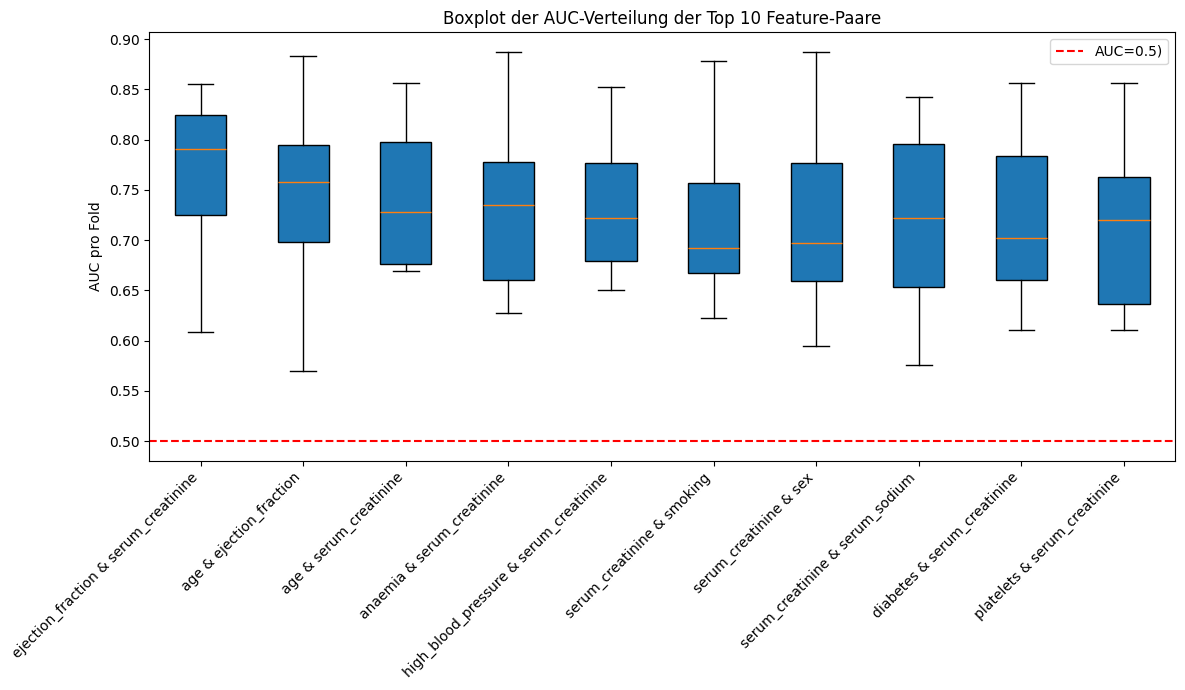

In [67]:
import itertools

feature_pairs = list(itertools.combinations(X.columns, 2))
pair_all_auc_scores = {}
pair_auc_scores = {}

for feature in feature_pairs:
    model = LogisticRegression()
    auc_scores = cross_val_score(
        model, X[list(feature)], y,
        cv=cv, 
        scoring='roc_auc'
    )

    auc_score = np.mean(auc_scores)
    pair_all_auc_scores[feature] = auc_scores
    pair_auc_scores[feature] = auc_score
    
sorted_pairs = sorted(pair_auc_scores.items(), key=lambda x: x[1], reverse=True)

# Hole Top 10 (oder alle, je nach Wunsch)
top_n = 10
top_pairs = [pair for pair, _ in sorted_pairs[:top_n]]

# Hole AUC-Werte pro Fold für Top Paare
boxplot_data = [pair_all_auc_scores[pair] for pair in top_pairs]
labels = [f"{p[0]} & {p[1]}" for p in top_pairs]

# Plot
plt.figure(figsize=(12, 7))
plt.boxplot(boxplot_data, labels=labels, patch_artist=True)
plt.xticks(rotation=45, ha='right')
plt.axhline(0.5, color='red', linestyle='--', label='AUC=0.5)')
plt.ylabel("AUC pro Fold")
plt.title(f"Boxplot der AUC-Verteilung der Top {top_n} Feature-Paare")
plt.legend()
plt.tight_layout()
plt.show()

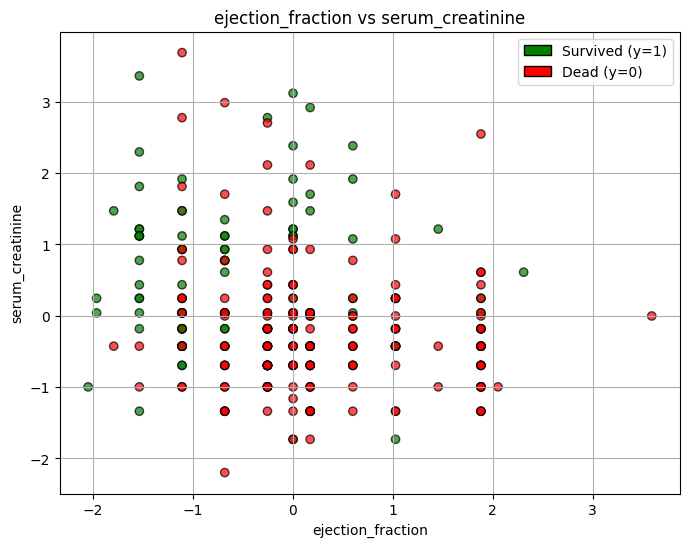

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


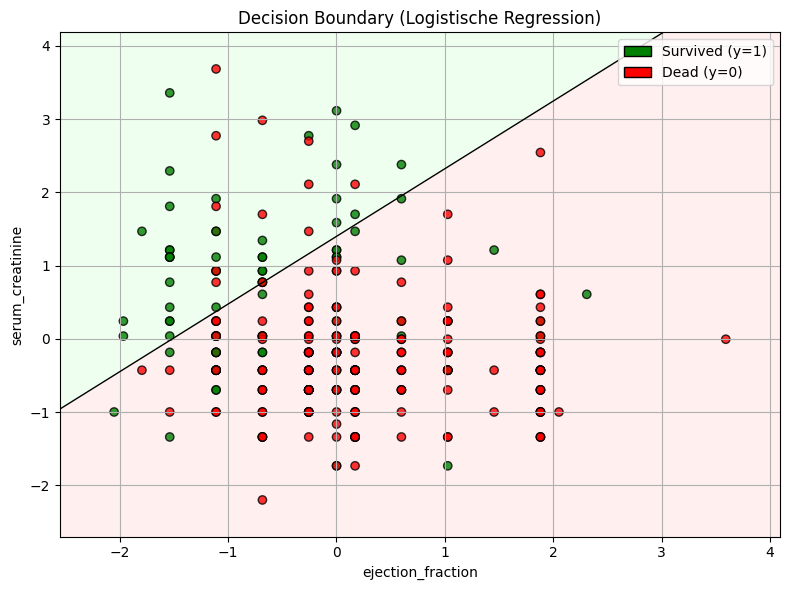

In [68]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Zwei Features wählen
feature_x = 'ejection_fraction'
feature_y = 'serum_creatinine'

# Farben basierend auf y
colors = np.where(y == 1, 'green', 'red')

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X[feature_x], X[feature_y], c=colors, alpha=0.7, edgecolor='k')
plt.xlabel(feature_x)
plt.ylabel(feature_y)
plt.title(f'{feature_x} vs {feature_y}')
plt.grid(True)
legend_elements = [
    Patch(facecolor='green', edgecolor='k', label='Survived (y=1)'),
    Patch(facecolor='red', edgecolor='k', label='Dead (y=0)')
]
plt.legend(handles=legend_elements)
plt.show()

# Zwei Features auswählen
X_2d = X[[feature_x, feature_y]]

# Modell trainieren
model = LogisticRegression()
model.fit(X_2d, y)

# Gitter für den Hintergrund erzeugen
x_min, x_max = X_2d[feature_x].min() - 0.5, X_2d[feature_x].max() + 0.5
y_min, y_max = X_2d[feature_y].min() - 0.5, X_2d[feature_y].max() + 0.5
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 500),
    np.linspace(y_min, y_max, 500)
)

# Vorhersage auf dem Gitter
grid = np.c_[xx.ravel(), yy.ravel()]
probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)

# Farben der Punkte je nach y
colors = y.map({1: 'green', 0: 'red'}) if hasattr(y, 'map') else np.where(y == 1, 'green', 'red')

# Plot
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, probs, levels=[0, 0.5, 1], colors=['#ffcccc', '#ccffcc'], alpha=0.3)
plt.contour(xx, yy, probs, levels=[0.5], colors='black', linewidths=1)

# Punkte plotten
plt.scatter(X_2d[feature_x], X_2d[feature_y], c=colors, edgecolor='k', alpha=0.8)

# Achsen & Titel
plt.xlabel(feature_x)
plt.ylabel(feature_y)
plt.title("Decision Boundary (Logistische Regression)")

# Legende
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', edgecolor='k', label='Survived (y=1)'),
    Patch(facecolor='red', edgecolor='k', label='Dead (y=0)'),
]
plt.legend(handles=legend_elements)

plt.grid(True)
plt.tight_layout()
plt.show()